<img src="https://media.giphy.com/media/Ycr587EkQo8KY/source.gif">


# **0. Introduction **

***

I reckon there there are people out there who have reason to be fearful of them as well. Having facing some wild encounters surfing in Cape Town, I still don't. But in fact sharks attacks are actually pretty peculiar and mysterious events that diserved to be investigated. There are about 80 reports of unprovoked shark worldwide each year, which may be a shock to you. Being a avid ocean lover, I wanted to see if there was anyway that the outcome following an event like this could be predicted.


The data is pulled from the International Shark Attack File, which was founded after a conference hosted in 1958 due to the US Navy’s particular interest in researching viable strategies to prevent shark attacks. According to the International Shark Attack File’s website, it stands as the “longest running database on shark attacks” and has “now more than 5900 individual investigations. I filtered the file between 2000 and 2020 for attacks happening in the USA? We are now working with 1000 incidents. 

[Our DataSet](/https://data.opendatasoft.com/explore/dataset/global-shark-attack@public-us/?flg=fr/)


# **1. Problem Identification**

***

The goal is to predict the survival or the death of a given personn based on a set of variables describing age, sex ..
So it is a classification problem and you are expected to predict Survived as 1 and Died as 0.

In [8]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import fuzzywuzzy
from fuzzywuzzy import process

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from collections import Counter
from sklearn.model_selection import train_test_split
import category_encoders as ce
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
from re import search
import geopandas


from sklearn.tree import DecisionTreeClassifier

sharks_attacks = pd.read_csv('../input/sharkssharks/sharkssharks.csv',error_bad_lines=False)



# **2. What data do we have ? **

***

In [9]:
sharks_attacks.head()

,Case Number,Date,Year,Type,Country,Area,Location,Address,Activity,Name,...,Longitude,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Precipitation Cover,Wind Speed,Wind Gust,Visibility,weather_info
0,2019.06.30,30/06/2019,2019,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County","New Smyrna Beach, Volusia County, Florida, USA",Surfing,male,...,"-80,9269984","86,2","73,0","80,1","1,1","12,5","9,1","29,8","9,7",NaN
1,2019.06.16.b,16/06/2019,2019,Unprovoked,USA,North Carolina,"Bald Head Island, Brunswick County","Bald Head Island, Brunswick County, North Caro...",Swimming,male,...,"-77,9944331999999","83,5","73,2","78,6","0,0","0,0","10,3",NaN,"10,0",NaN
2,2019.06.16.a,16/06/2019,2019,Unprovoked,USA,Georgia,"Wilmington River, Chatham County","Wilmington River, Chatham County, Georgia, USA",Swimming,Gene Brooks,...,"-80,9969719999999","88,3","70,8","80,0","0,0","0,0","13,9",NaN,"9,8",NaN
3,2019.06.10,10/06/2019,2019,Unprovoked,USA,North Carolina,"Ocean Isle, Brunswick County","Ocean Isle, Brunswick County, North Carolina, USA",Surfing,Austin Reed,...,"-78,426672","84,4","76,5","79,7","0,2","8,3","12,6",NaN,"9,5",NaN
4,2019.05.25.b,25/05/2019,2019,Unprovoked,USA,Hawaii,"Honokowai Point, Maui","Honokowai Point, Maui, Hawaii, USA",Swimming,Thomas Smiley,...,"-156,6920594","86,0","69,2","77,8","0,0","0,0","18,4","28,8","10,0",NaN


In [10]:
sharks_attacks.dtypes


Case Number               object
Date                      object
Year                       int64
Type                      object
Country                   object
Area                      object
Location                  object
Address                   object
Activity                  object
Name                      object
Sex                       object
Age                       object
Injury                    object
Fatal (Y/N)               object
Time                      object
Species                   object
Investigator or Source    object
pdf                       object
href formula              object
href                      object
original order             int64
Latitude                  object
Longitude                 object
Maximum Temperature       object
Minimum Temperature       object
Temperature               object
Precipitation             object
Precipitation Cover       object
Wind Speed                object
Wind Gust                 object
Visibility

Except the "Year" and "original order" columns, all the others contain texts.



At first I was thinking “ahh this should be a fun challenge” but the more and more I analyzed the data the less “fun” and more challenging it became.

# **3. Data Preparation **


First, let's check the null values and replace them with NaN. This will indeed helps generating efficient insights. 

In [11]:

sharks_attacks.isnull().sum()

Case Number                 0
Date                        0
Year                        0
Type                        0
Country                     0
Area                        0
Location                    6
Address                     0
Activity                   49
Name                        9
Sex                        26
Age                       197
Injury                      0
Fatal (Y/N)                56
Time                      164
Species                   377
Investigator or Source      2
pdf                         0
href formula                0
href                        0
original order              0
Latitude                    0
Longitude                   0
Maximum Temperature        18
Minimum Temperature        18
Temperature                18
Precipitation              18
Precipitation Cover        18
Wind Speed                 19
Wind Gust                 872
Visibility                 23
weather_info              980
dtype: int64

In [12]:
sharks_attacks=sharks_attacks.fillna(method="ffill")
sharks_attacks.isnull().sum()

Case Number                0
Date                       0
Year                       0
Type                       0
Country                    0
Area                       0
Location                   0
Address                    0
Activity                   0
Name                       0
Sex                        0
Age                        0
Injury                     0
Fatal (Y/N)                0
Time                       0
Species                    2
Investigator or Source     0
pdf                        0
href formula               0
href                       0
original order             0
Latitude                   0
Longitude                  0
Maximum Temperature        0
Minimum Temperature        0
Temperature                0
Precipitation              0
Precipitation Cover        0
Wind Speed                 0
Wind Gust                  0
Visibility                 0
weather_info              24
dtype: int64

In [13]:
try:
    sharks_attacks['Year_']=[d[0:4] for d in sharks_attacks['Case Number']]
except:
    data['Year_']='00'
try:
    sharks_attacks['Month']=[d[5:7] for d in sharks_attacks['Case Number']]
except:
    sharks_attacks['Month']='00'
try:
    sharks_attacks['Day']=[d[8:10] for d in sharks_attacks['Case Number']]
except:
    sharks_attacks['Day']='00'
sharks_attacks.loc[sharks_attacks['Year_'].str.contains('(?i)ND'),'Year_']='00'
sharks_attacks.loc[sharks_attacks['Year_'].str.contains('ND'),'Day']='00'
sharks_attacks.loc[sharks_attacks['Year_'].str.contains('ND'),'Month']='00'
sharks_attacks['Year_'] = sharks_attacks['Year_'].replace(['0.02','0.03','0.04','0.07'],0)
sharks_attacks['Year_'] = sharks_attacks['Year_'].astype(int)
sharks_attacks = sharks_attacks[['Case Number','Day','Month','Year_','Date','Type','Name','Location','Activity',"Area",
           'Sex ','Age','Fatal (Y/N)','Species ',"Latitude","Longitude","Temperature","href"]]
sharks_attacks.sample(n=10)

,Case Number,Day,Month,Year_,Date,Type,Name,Location,Activity,Area,Sex,Age,Fatal (Y/N),Species,Latitude,Longitude,Temperature,href
188,2015.12.23,23,12,2015,07/11/2015,Invalid,Ryla Underwood,"Paradise Beach, Melbourne, Brevard County",Surfing,Florida,F,9,N,Shark involvement not confirmed,"28,1224397","-80,5760512999999","80,0",http://sharkattackfile.net/spreadsheets/pdf_di...
288,2014.07.16,16,07,2014,16/07/2014,Unprovoked,male,"Paia Bay, Maui",Swimming,Hawaii,M,61,N,6' to 8' shark,"20,9173854999999","-156,3836273","80,2",http://sharkattackfile.net/spreadsheets/pdf_di...
312,2013.12.11,11,12,2013,11/12/2013,Unprovoked,male,"Ninole Bay, Hawaii County",Boogie boarding,Hawaii,M,29,N,"Tiger shark, 10' to 12'","19,9591667","-155,1975","68,5",http://sharkattackfile.net/spreadsheets/pdf_di...
564,2008.08.28,28,08,2008,28/08/2008,Unprovoked,Thomas Gold,"New Smyrna Beach, Volusia County",Surfing,Florida,M,19,N,Shark involvement not confirmed,"29,0258191","-80,9269984","82,1",http://sharkattackfile.net/spreadsheets/pdf_di...
102,2017.04.20,20,04,2017,20/04/2017,Invalid,male,Georgetown County,Swimming,South Carolina,M,33,N,Shark involvement not confirmed,"33,4213399","-79,2902133","69,6",http://sharkattackfile.net/spreadsheets/pdf_di...
648,2007.06.30.b,30,06,2007,30/06/2007,Provoked,Samuel Gruber,Marques Island,Removing hook from shark,Florida,M,18,N,"Lemon shark, 6' female","24,5754474","-82,1033464","85,5",http://sharkattackfile.net/spreadsheets/pdf_di...
728,2005.10.21,21,10,2005,21/10/2005,Unprovoked,Chad Reiker,"Klamath River mouth, Del Norte County",Surfing,California,M,36,N,White shark,"41,7076287","-123,9659708","48,3",http://sharkattackfile.net/spreadsheets/pdf_di...
881,2002.06.11.a,11,06,2002,10/06/2002,Unprovoked,Jason Smith,"St Augustine Beach, St Johns County",Surfing,Florida,M,28,N,0.9 m to 1.2 m [3' to 4'] shark; Tooth fragmen...,"29,8439827999999","-81,2711546","77,7",http://sharkattackfile.net/spreadsheets/pdf_di...
225,2015.06.25,25,06,2015,25/06/2015,Unprovoked,Patrick Thornton,"Avon, Hatteras Island, Outer Banks, Dare County",Body surfing?,North Carolina,M,47,N,Shark involvement not confirmed,"35,3521855","-75,5108445","79,5",http://sharkattackfile.net/spreadsheets/pdf_di...
502,2010.06.27,27,06,2010,27/06/2010,Unprovoked,Chad Rogers,"Eight Mile Beach, Galveston",Surfing,Texas,M,20,N,"Bull shark, 5'","29,2570461999999","-94,8948853","86,3",http://sharkattackfile.net/spreadsheets/pdf_di...


First, let's have a look at the column "names"

### Sex and name column

I notice that in the "Name" column there is some informations that should be in the "Sex" column.

In [14]:
def correct_name(row):
    if row["Name"] == "girl" or row["Name"] == "Girl":
        return "Unknown"
    elif row["Name"] == "boy" or row["Name"] == "Boy":
        return "Unknown"
    elif row["Name"] == "male" or row["Name"] == "Male":
        return "Unknown"
    elif row["Name"] == "female" or row["Name"] == "Female":
        return "Unknown"    
    else:
        return row["Name"]
    
sharks_attacks["Name"] = sharks_attacks.apply(correct_name, axis=1)

Let's check if these informations could help filling the empty cells of the "Sex" column.
First, there is something we really don't like in Data cleaning : a space in the column's name! Let's clean every columns' name to be sure.

In [15]:
sharks_attacks.rename(columns={'Sex ': 'Sex'}, inplace=True)
sharks_attacks.columns = sharks_attacks.columns.str.strip()

In [16]:
set(sharks_attacks['Name'].sample(n=40))


{None, 'Unknown'}

We can now observe that the column has been cleaned out.

In [17]:
sharks_attacks['Sex'] = sharks_attacks['Sex'].str.replace('N', 'M')
sharks_attacks['Sex'] = sharks_attacks['Sex'].str.strip()
sharks_attacks['Sex'] = sharks_attacks['Sex'].fillna('Unknown')
sharks_attacks['Sex'] = sharks_attacks['Sex'].str.replace('lli', 'Unknown')
sharks_attacks['Sex'] = sharks_attacks['Sex'].str.replace('.', 'Unknown')
set(sharks_attacks['Sex'])

{'F', 'M', 'Unknown'}

### Fatal column

In [18]:
sharks_attacks['Fatal (Y/N)'] = sharks_attacks['Fatal (Y/N)'].str.strip()
sharks_attacks['Fatal (Y/N)'] = sharks_attacks['Fatal (Y/N)'].fillna('U')
sharks_attacks['Fatal (Y/N)'] = sharks_attacks['Fatal (Y/N)'].str.replace('n', 'N')
sharks_attacks['Fatal (Y/N)'] = sharks_attacks['Fatal (Y/N)'].str.replace('#VALUE!', 'U')
sharks_attacks['Fatal (Y/N)'] = sharks_attacks['Fatal (Y/N)'].str.replace('F', 'Y')
sharks_attacks['Fatal (Y/N)'] = sharks_attacks['Fatal (Y/N)'].str.replace('UNKNOWN', 'U')
print(set(sharks_attacks['Fatal (Y/N)']))

{'U', 'Y', 'N'}


### "Type" column


In [19]:
set(sharks_attacks['Type'])


{'Invalid',
 'Provoked',
 'Questionable',
 'Sea Disaster',
 'Under investigation',
 'Unprovoked',
 'Watercraft'}

Surprinsingly, the 'Type' column is almost clean !



In [20]:
sharks_attacks['Type'] = sharks_attacks['Type'].str.strip()
sharks_attacks['Type'] = sharks_attacks['Type'].str.replace('Watercraft','Boat incident')
sharks_attacks['Type'] = sharks_attacks['Type'].str.replace('Sea Disaster','Boat incident')
sharks_attacks['Type'] = sharks_attacks['Type'].str.replace('Invalid','Unknown')
sharks_attacks['Type'] = sharks_attacks['Type'].str.replace('Questionable','Unknown')
sharks_attacks['Type'] = sharks_attacks['Type'].str.replace('Under investigation','Unknown')


print(set(sharks_attacks['Type']))


{'Unprovoked', 'Boat incident', 'Unknown', 'Provoked'}


### "Species" column


Let's have a look at the set of values.

In [21]:
print(set(sharks_attacks['Species']))


{nan, 'Blacktip shark', '2 m to 3 m shark', "A 2' shark was seen in the area by witnesses", "White shark, 7'", '15 cm to 20 cm [6" to 8"] bite diameter just below left knee', "Thought to involve a 2.7 m [9'], 400-lb bull shark", 'small hammerhead shark', "3' to 4' shark", "4' to 6' shark", 'Thought to involve a mako shark, but possibly a sea lion', "Bull shark, 6'", "6' to 8' shark", "Blacktip shark, 1.2 m to 1.8 m [4' to 6'] ", 'reef shark?', 'Shark involvement probable, but not confirmed', 'No shark involvement', "4' tp 5' shark", "+3' shark", 'Possibly a juvenile blacktip or spinner shark', "Sevengill shark, 6' to 8'", "5' to 7' shark", "6' shark, possibly a blactip or spinner shark", 'Spinner shark or blacktip shark', "1.2 m [4'] shark", "8' bull shark or Caribbean reef shark", "Tiger shark, 7'", 'Mako shark, 100-lb', "Whitetip reef shark, 4' to 6'", "Blacktip or spinner shark, 4'", '18" to 36" shark', "Blacktip shark, 4' to 5'", "Nurse shark, 3' ", "Tiger shark, 2.4 m to 2.7 m [8'

This column needs a big cleaning but its informations are not pertinent for an analysis in my opinion. I decide to clean it just a little by filling the empty cells with 'Unknown'and using fuzzy matching to correct inconsistent data entry.



In [22]:
sharks_attacks['Species'].fillna('Unknown', inplace=True)
sharks_attacks['Species'] = sharks_attacks['Species'].str.lower()



def replace_matches_in_column(df, column, string_to_match):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=1000, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    


    # only get matches with a ratio > 20
    close_matches = []
                                                            
    
    for match in matches:
        if search(string_to_match, match[0]):
            close_matches.append(match[0])
                      
    # get the rows of all the close matches in our dataframe


    rows_with_matches = df[column].isin(close_matches)

    

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match


    # let us know the function's done
    print("All done!" + string_to_match )
    
   

print(set(sharks_attacks['Species']))

    
replace_matches_in_column(df=sharks_attacks, column='Species', string_to_match="white")
replace_matches_in_column(df=sharks_attacks, column='Species', string_to_match="tiger")
replace_matches_in_column(df=sharks_attacks, column='Species', string_to_match="bull")
replace_matches_in_column(df=sharks_attacks, column='Species', string_to_match="hammerhead")
replace_matches_in_column(df=sharks_attacks, column='Species', string_to_match="nurse")
replace_matches_in_column(df=sharks_attacks, column='Species', string_to_match="spinner")
replace_matches_in_column(df=sharks_attacks, column='Species', string_to_match="mako")
replace_matches_in_column(df=sharks_attacks, column='Species', string_to_match="shark")

print(set(sharks_attacks['Species']))




{"white shark, female, 14'", "bull shark, 12'", '2 m to 3 m shark', 'sandtiger shark', "tiger shark, 7'", 'shark involvement prior to death not confirmed', "3' to 4' shark", 'hammerhead sp.', "4' to 6' shark", 'small hammerhead shark', '15 cm to 20 cm [6" to 8"] bite diameter just below left knee', "nurse shark, 6'", "lemon shark, 3'", 'shark involvement unconfirmed but considered probable', 'possibly juvenile tiger shark', "sandtiger shark, 2.1 m [7'] ", "6' to 8' shark", "blacktip shark, 2.4 m to 3 m [8' to 10'] ", 'reef shark?', "4' tp 5' shark", "+3' shark", 'unknown', "white shark, 10'", 'spinner shark or blacktip shark', "5' to 7' shark", "6' shark, possibly a blactip or spinner shark", "tiger shark, 14' ", "1.2 m [4'] shark", "tiger shark, 2.4 m to 2.7 m [8' to 9']  ", "2' to 3.5' shark", '18" to 36" shark', 'unidentified species', "8' to 10' shark", "3.5' to 4' shark", 'bull shark', "1.5 m [5'] shark", 'possibly a juvenile blacktip shark', "white shark, 12' to 14'", "white shar

Now let's strip out the last unwanted values according to the last console print and keep the main known species known for attacks which are : 
* White
* Mako
* Tiger
* Hammerhead
* Nurse
* Bull
* Spinner

In [23]:
main_species = ['white','mako','tiger','hammerhead','nurse','bull','spinner']


values_species = set(sharks_attacks['Species'])

for item in values_species:
    if item not in main_species and len(item)>1:
        sharks_attacks['Species'] = sharks_attacks['Species'].replace(to_replace = item, value = "Unknown") 


print(set(sharks_attacks['Species']))

{'nurse', 'white', 'spinner', 'tiger', 'Unknown', 'hammerhead', ' ', 'mako', 'bull'}


In [24]:
sharks_attacks['Species'].fillna('Unknown', inplace=True)

sharks_attacks.head()


,Case Number,Day,Month,Year_,Date,Type,Name,Location,Activity,Area,Sex,Age,Fatal (Y/N),Species,Latitude,Longitude,Temperature,href
0,2019.06.30,30,06,2019,30/06/2019,Unprovoked,Unknown,"New Smyrna Beach, Volusia County",Surfing,Florida,M,18,N,Unknown,"29,0258191","-80,9269984","80,1",http://sharkattackfile.net/spreadsheets/pdf_di...
1,2019.06.16.b,16,06,2019,16/06/2019,Unprovoked,Unknown,"Bald Head Island, Brunswick County",Swimming,North Carolina,M,8,N,Unknown,"33,8618418","-77,9944331999999","78,6",http://sharkattackfile.net/spreadsheets/pdf_di...
2,2019.06.16.a,16,06,2019,16/06/2019,Unprovoked,None,"Wilmington River, Chatham County",Swimming,Georgia,M,64,N,bull,"31,9944425","-80,9969719999999","80,0",http://sharkattackfile.net/spreadsheets/pdf_di...
3,2019.06.10,10,06,2019,10/06/2019,Unprovoked,None,"Ocean Isle, Brunswick County",Surfing,North Carolina,M,19,N,bull,"33,8943393","-78,426672","79,7",http://sharkattackfile.net/spreadsheets/pdf_di...
4,2019.05.25.b,25,05,2019,25/05/2019,Unprovoked,None,"Honokowai Point, Maui",Swimming,Hawaii,M,65,Y,bull,"20,9479024","-156,6920594","77,8",http://sharkattackfile.net/spreadsheets/pdf_di...


### "Age" Column

In [25]:
def age_process(age):
    try:
        age = int(age)
    except:
        age = 0
    if (age > 0 and age <= 100):
        return age
    else:
        return np.nan
    
    
def categorize_age(age):
    try:
        age = int(age)
    except:
        age = 0
    if (age > 0 and age <= 20):
        return 1
    if (age > 20 and age <= 40):
        return 2
    if (age > 40 and age <= 60):
        return 3
    if (age > 60 and age <= 80):
        return 4
    if (age > 80 ):
        return 5

sharks_attacks['Age'] = sharks_attacks['Age'].apply(age_process)
print(sharks_attacks['Age'])

sharks_attacks.insert(2, "AgeCat",'cat') 

sharks_attacks['AgeCat'] = sharks_attacks['Age'].apply(categorize_age)

print(sharks_attacks['AgeCat'])

0      18.0
1       8.0
2      64.0
3      19.0
4      65.0
       ... 
993    34.0
994    14.0
995    37.0
996    39.0
997    27.0
Name: Age, Length: 998, dtype: float64
0      1.0
1      1.0
2      4.0
3      1.0
4      4.0
      ... 
993    2.0
994    1.0
995    2.0
996    2.0
997    2.0
Name: AgeCat, Length: 998, dtype: float64




# **4. Some useful insight **

***

### Per year

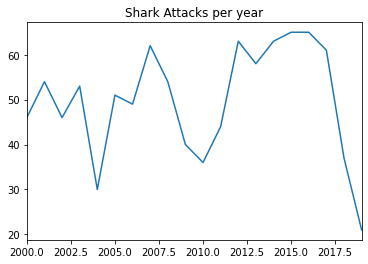

In [26]:
Years_values = sharks_attacks['Year_'].value_counts().sort_index()
Years_values.plot(title="Shark Attacks per year")


### Per Month

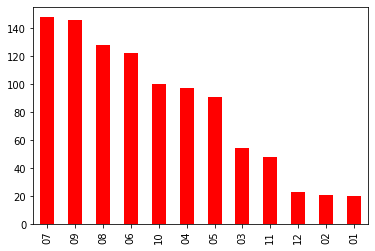

In [27]:
sharks_attacks.groupby("Month")\
  .filter(lambda x: len(x) > 1)\
  .Month.value_counts()\
  .plot.bar(color='red')

### Per sex

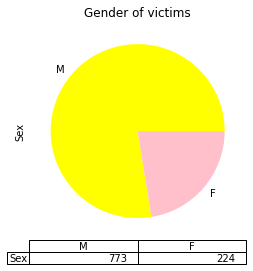

In [28]:
sharks_attacks[sharks_attacks['Sex'].isin(['M','F'])]["Sex"].value_counts().plot(kind='pie',title= "Gender of victims",colors= ['yellow','pink'], table =True)

### Per activity

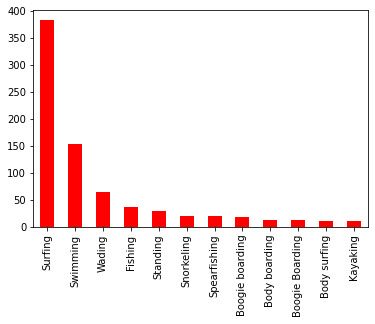

In [29]:
sharks_attacks.groupby("Activity")\
  .filter(lambda x: len(x) > 10)\
  .Activity.value_counts()\
  .plot.bar(color='red')

### Per species

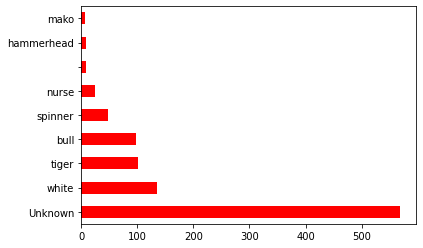

In [30]:
sharks = sharks_attacks['Species'].value_counts()
sharks[sharks>5].plot.barh(color='red')

### Per State

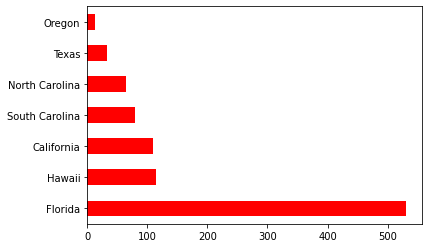

In [31]:

sharks_attacks.groupby("Area")\
  .filter(lambda x: len(x) > 10)\
  .Area.value_counts()\
  .plot.barh(color='red')

### Per age

Text(0.5, 1.0, 'Age Distribution')

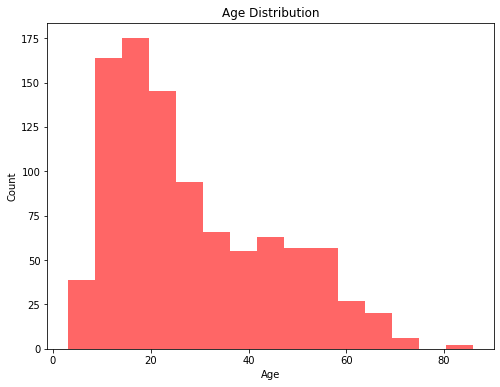

In [32]:
fig,ax = plt.subplots(figsize=(8,6))
ax = sns.distplot(sharks_attacks['Age'].dropna().astype(np.int32),
             ax=ax,
             hist_kws={"alpha": 0.6, "color": "#FF0000"},
             kde=False,bins=15)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

### Fatal ?

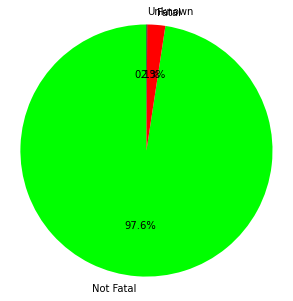

In [33]:
fatal_vals = sharks_attacks['Fatal (Y/N)'].value_counts().tolist()


f, ax = plt.subplots(figsize=(5, 5))

labels = ['Not Fatal', 'Fatal', 'Unknown']
colors = ['#00FF00', '#FF0000', '#000000']

plt.pie(fatal_vals, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
 
axis = plt.axis('equal')

### Provoked ?

“Unprovoked attacks” are defined as incidents where an attack on a live human occurs in the shark’s natural habitat with no human provocation of the shark.

“Provoked attacks” occur when a human initiates interaction with a shark in some way. These include instances when divers are bitten after harassing or trying to touch sharks, attacks on spearfishers, attacks on people attempting to feed sharks, bites occurring while unhooking or removing a shark from a fishing net, and so forth.

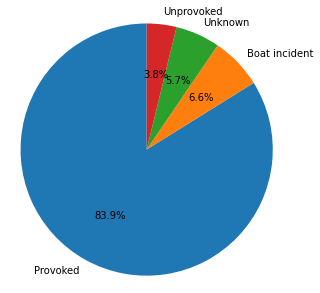

In [34]:
type_vals = sharks_attacks['Type'].value_counts().tolist()


f, ax = plt.subplots(figsize=(5, 5))

labels = ['Provoked', 'Boat incident', 'Unknown', 'Unprovoked']

plt.pie(type_vals, labels=labels,
        autopct='%1.1f%%', startangle=90)
 
axis = plt.axis('equal')

# **5. Model **

Let's convert some values and save the clean file !

In [35]:
### We want a binary value as a result  

sharks_attacks.rename(columns={'Fatal (Y/N)': 'Fatal'}, inplace=True)
sharks_attacks.Fatal[sharks_attacks.Fatal == 'Y'] = 1
sharks_attacks.Fatal[sharks_attacks.Fatal == 'N'] = 0
sharks_attacks.Fatal[sharks_attacks.Fatal == 'U'] = 0 

### We may neet clean coordinates 
sharks_attacks['Longitude'] = sharks_attacks['Longitude'].str.replace(',', '.').astype(float)
sharks_attacks['Latitude'] = sharks_attacks['Latitude'].str.replace(',', '.').astype(float)


sharks_attacks = sharks_attacks[['Type','Date','Name','Location','Activity','Area','Sex',"Fatal","Species","Latitude","Longitude","AgeCat","href","Age"]]




sharks_attacks.to_csv('GSAF5.csv', index=False)
sharks_attacks = sharks_attacks[['Type','AgeCat','Activity','Area','Sex','Fatal','Species']]
sharks_attacks.to_csv('GSAF5_clean.csv', index=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's split the Dataframe in 2 parts (train and test) in order to use to ML algorithms

In [36]:
sharks_attacks.head()
encoder = ce.BinaryEncoder(cols=["Type",'Sex',"Area","Species","Activity","AgeCat"])
df_binary = encoder.fit_transform(sharks_attacks)

training, testing = train_test_split(df_binary, test_size=0.2, random_state=0)


df_binary.head()


,Type_0,Type_1,Type_2,AgeCat_0,AgeCat_1,AgeCat_2,AgeCat_3,Activity_0,Activity_1,Activity_2,...,Area_5,Sex_0,Sex_1,Sex_2,Fatal,Species_0,Species_1,Species_2,Species_3,Species_4
0,0,0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0


Let's separate inputs and outputs.

In [37]:


X = training.loc[:, training.columns != 'Fatal']
y = np.ravel(training.loc[:,['Fatal']])




X_test = testing.loc[:, testing.columns != 'Fatal']
y_test = np.ravel(testing.loc[:,['Fatal']])

print(X.shape)
print(y.shape)

print(X_test.shape)
print(y_test.shape)

(798, 30)
(798,)
(200, 30)
(200,)


Now we are going to use a RandomForestClassifier.
Random forest classifier creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object.

In [38]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

rdmf = RandomForestClassifier()
y = y.astype('int') 
y_test = y_test.astype('int') 
rdmf.fit(X, y)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

acc_random_forest = round(rdmf.score(X, y) * 100, 2)




### Decision Tree

In [39]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X, y)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X, y) * 100, 2)
acc_decision_tree

99.62

### Gaussian Native Bayes

In [40]:
# Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
gaussian.fit(X, y)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X, y) * 100, 2)
acc_gaussian

9.52

### KNN

In [41]:
# KNN


from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X, y)
Y_pred = knn.predict(X_test)
print(Y_pred)
acc_knn = round(knn.score(X, y) * 100, 2)
acc_knn

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


97.49

### Logistic Regression

In [42]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X, y)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X, y) * 100, 2)
acc_log

97.49

### Support Vector Machines

In [43]:
# Support Vector Machines

svc = SVC()
svc.fit(X, y)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X, y) * 100, 2)
acc_svc

97.49

Let's rank those scores !

In [44]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest','Gaussian','Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian,acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,99.62
5,Decision Tree,99.62
0,Support Vector Machines,97.49
1,KNN,97.49
2,Logistic Regression,97.49
4,Gaussian,9.52



# **6. Model Evaluation ? **




Unfortunately there are many limitations of my analysis due to the nature of my dataset. Firstly, there is just the question of whether all shark attacks are even reported to this database in the first place. Presumably it would require the victim or someone aware of the attack to know about the database in order to ultimately report the attack. While this may be fair to assume is true in areas with large population of well-educated health care professionals and access to computers/internet, this may not be as fair to assume in more remote or developing countries. Additionally, the issue of bad press for tourism could result into the discouragement of reporting a shark attacks.

Another limitation of my analysis arises from not only whether attacks are reported but also how they are reported. The dataset is incredibly text heavy and the responses were not limited to set answers, rather the reports of each attack were all incredibly unique. For example, this biggest issue this caused was for the variable “Activity” (the activity the victim was engaging in when the attack occurred). The responses to this question were not limited to a asset number of different options that one would likely be doing when attacked by a shark (e.g. Swimming, Fishing, Surfing, etc.). Instead, many of the entries were longer, personalized, and high anecdotal. For example: “Swimming after a tennis ball” was one response and despite the fact that the victim was simply swimming, the more specific is coded and recognized differently from all the other victims who simply entered. 



So you might be asking, does this model really help in predicting the result of a shark attack. Maybe. Yes because shark attacks are peculiar event that result in a fatality about 25% of the time, but it isn't a good predictor of the question “If I were to go to a beach, what are my chances of getting into a fatal shark attack based on these conditions?”. This model would be useful for some sort of simulation or game where you just want to use the results as probabilities for an outcome or just if you wanted to get a more in depth reasoning behind how a model makes predictions with the data given to it.
If i were to go to surfing in Florida, what are my chances of being in a fatal attack with a Bull shark?”. I plan on continuing to work on this problem and upload a web app so that people can do these types of interactive predictions, but for now I hope this was as interesting for you to read as it was for me to work on.